In [1]:
# library to import .mat file
import scipy.io as sio
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the .mat file
preProcess = ['TCC']
Thrs = ['GL','LG','LT','SD']
MeMs =['Fastcore','TOCS']
# dataframe to store the data
df = pd.DataFrame(columns=['Threshold','MeM','Model','T_Blocked_count','F_Blocked_count','Size'])
for pre in preProcess:
    for thr in Thrs:
        for mem in MeMs:
            for i in range(1,65):
                # loading the results of blocked reactions
                data = sio.loadmat('./Kim_et_al/TCC_results/'+pre+'/'+thr+'/'+mem+'/m'+str(i)+'.mat')
                T_Blocked_count=len([i[0][0] for i in data['a'] if i[0][0]=='Blocked'])
                data2 = sio.loadmat('./Kim_et_al/FCC_results/'+pre+'/'+thr+'/'+mem+'/m'+str(i)+'.mat')
                F_Blocked_count=len(data['a']) - len(data2['a'])

                # loading the models
                model = sio.loadmat('./Kim_et_al/models/'+pre+'/'+thr+'/'+mem+'/m'+str(i)+'.mat')
                size = len(model['m'][0][0][4])
                # concatinating the data
                df_temp = pd.DataFrame({'PreProcess':pre,'Threshold':thr,'MeM':mem,'Model':'E'+str(2198+i),'T_Blocked_count':T_Blocked_count,
                    'F_Blocked_count':F_Blocked_count,'Size':size},index=[0])
                df = pd.concat([df,df_temp])
df = df.reset_index(drop=True)
df['Threshold'] = df['Threshold'].map({'GL':'Global-80','LG':'LocalGini','LT':'LocalT2','SD':'StanDep'})
df['Pre-Processing Method'] = df['PreProcess'].map({'FCC':'FastCC','TCC':'ThermOptCC'})
df.T_Blocked_count = df.T_Blocked_count - df.F_Blocked_count
df.head()


,Threshold,MeM,Model,T_Blocked_count,F_Blocked_count,Size,PreProcess,Pre-Processing Method
0,Global-80,Fastcore,E2199,0,0,1015,TCC,ThermOptCC
1,Global-80,Fastcore,E2200,7,0,834,TCC,ThermOptCC
2,Global-80,Fastcore,E2201,2,0,1023,TCC,ThermOptCC
3,Global-80,Fastcore,E2202,7,0,1060,TCC,ThermOptCC
4,Global-80,Fastcore,E2203,0,0,909,TCC,ThermOptCC


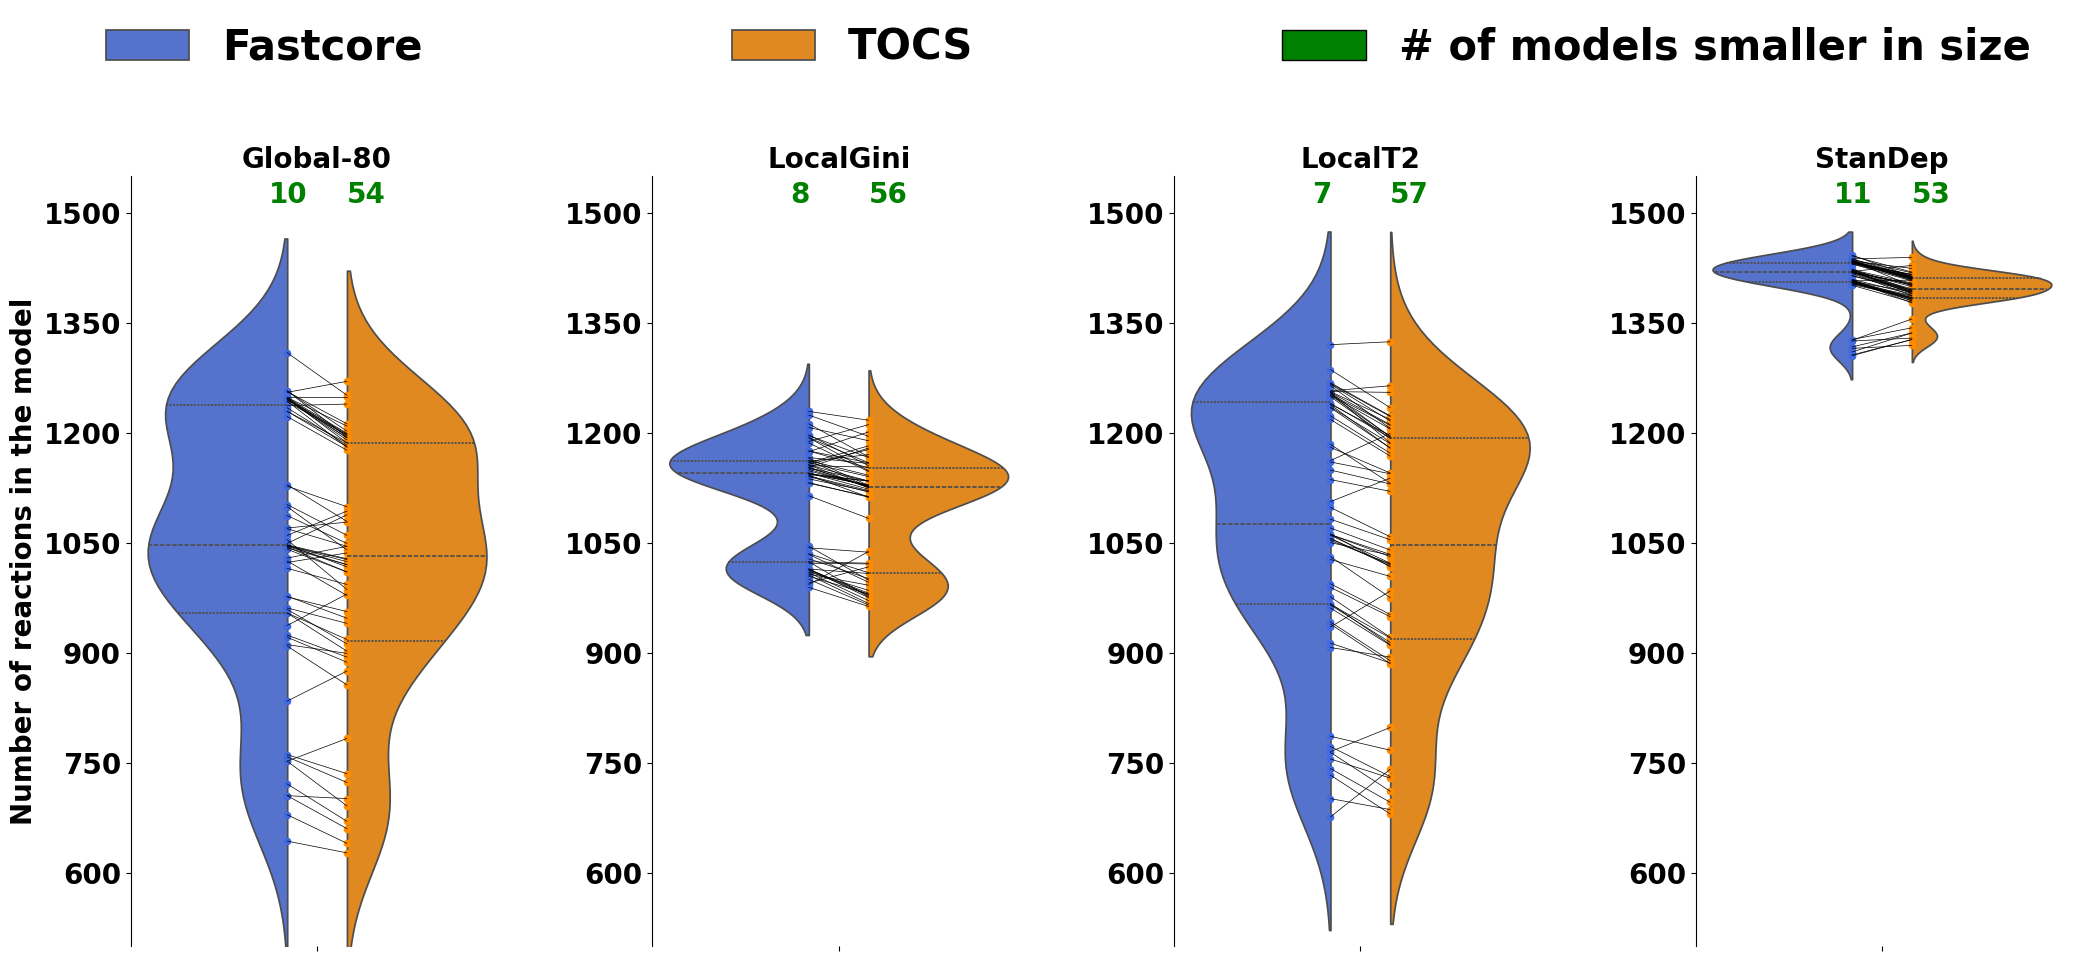

In [8]:
# plotting box plot based on the size of the models
fig,ax = plt.subplots(1,4,figsize=(25,10))
ax = ax.flatten()
models = df['Model'].unique()
pal={'Fastcore':'royalblue','TOCS':'darkorange'}
yticks = np.arange(600,1501,150)
for i,thr in enumerate(df['Threshold'].unique()):
    df1=df[(df['Threshold']==thr) & (df['MeM']!='Swiftcore')]
    # making a half violin plot
    sns.violinplot(y='Size',hue='MeM',split=True,gap=0.3,data=df1,ax=ax[i],inner="quart",palette=pal)
    ax[i].set_title(thr,fontsize=20,fontweight='bold')
    # making the spines off
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].set_ylabel('',fontsize=1,fontweight='bold')
    # setting the ylim 
    ax[i].set_ylim(500,1550)
    # ax[i].set_xlabel('Model extraction method',fontsize=12,fontweight='bold')
    
    # making the ticlabels bold
    ax[i].set_xticklabels(ax[i].get_xticklabels(),fontweight='bold',fontsize=20)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels(ax[i].get_yticklabels(),fontweight='bold',fontsize=20)
    count_of_smaller = {'Fastcore':0,'TOCS':0}
    # making a slope plot
    for m in models:
        df2 = df1[df1['Model']==m]
        ax[i].scatter([-0.06],df2[df2['MeM']=='Fastcore']['Size'],color='royalblue',s=20)
        ax[i].scatter([0.06],df2[df2['MeM']=='TOCS']['Size'],color='darkorange',s=20)
        ax[i].plot([-0.06,0.06],df2['Size'],'-',color='k',linewidth=0.5)
        if df2[df2['MeM']=='Fastcore']['Size'].values[0]<df2[df2['MeM']=='TOCS']['Size'].values[0]:
            count_of_smaller['Fastcore']+=1
        else:
            count_of_smaller['TOCS']+=1
    # adding the text
    ax[i].text(0.37,0.965,str(count_of_smaller['Fastcore']),transform=ax[i].transAxes,fontsize=20,fontweight='bold',color = 'green')
    ax[i].text(0.58,0.965,str(count_of_smaller['TOCS']),transform=ax[i].transAxes,fontsize=20,fontweight='bold',color = 'green')
ax[0].set_ylabel('Number of reactions in the model',fontsize=20,fontweight='bold')
# switching off all the legends
for a in ax[:-1]:
    a.get_legend().remove()
handles, labels = ax[-1].get_legend_handles_labels()

# adding the legend
handles.append(Rectangle((0,0),1,1,fc="green", edgecolor = 'k'))
labels.append('# of models smaller in size')
fig.legend(handles,labels, loc='lower center', bbox_to_anchor=(0.1, 0.95, 0.8, 0.9),frameon=0,mode='expand',ncol=3,prop={'size':30,'weight':'bold'})
ax[-1].get_legend().remove()
# allowing space between the plots
plt.subplots_adjust(wspace=0.4)
plt.savefig('FC_TOCS_model_size.pdf',bbox_inches='tight')